In [1]:
import galsim
from galsim.bounds import _BoundsI
import tensorflow as tf
import tensorflow_hub as hub
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
STAMP_SIZE = 128
PIXEL_SCALE = 0.03

In [3]:
# Load autoencoder model
encoder = hub.Module('modules/vae_16/encoder')
decoder = hub.Module('modules/vae_16/decoder')

In [4]:
# Loads COSMOS sample
cosmos_cat = galsim.COSMOSCatalog()

/gpfslocalsup/pub/anaconda-py3/2019.03/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [5]:
batch_size =1
psf_in = tf.placeholder(shape=[batch_size, 256, 129, 1], dtype=tf.float32)
im_in = tf.placeholder(shape=[batch_size, 128, 128, 1], dtype=tf.float32)

code = encoder({'input':im_in, 'psf':psf_in})
reconstruction = decoder(code)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [9]:
# some interesting examples from the test set
indices = [81005,80252,80203]

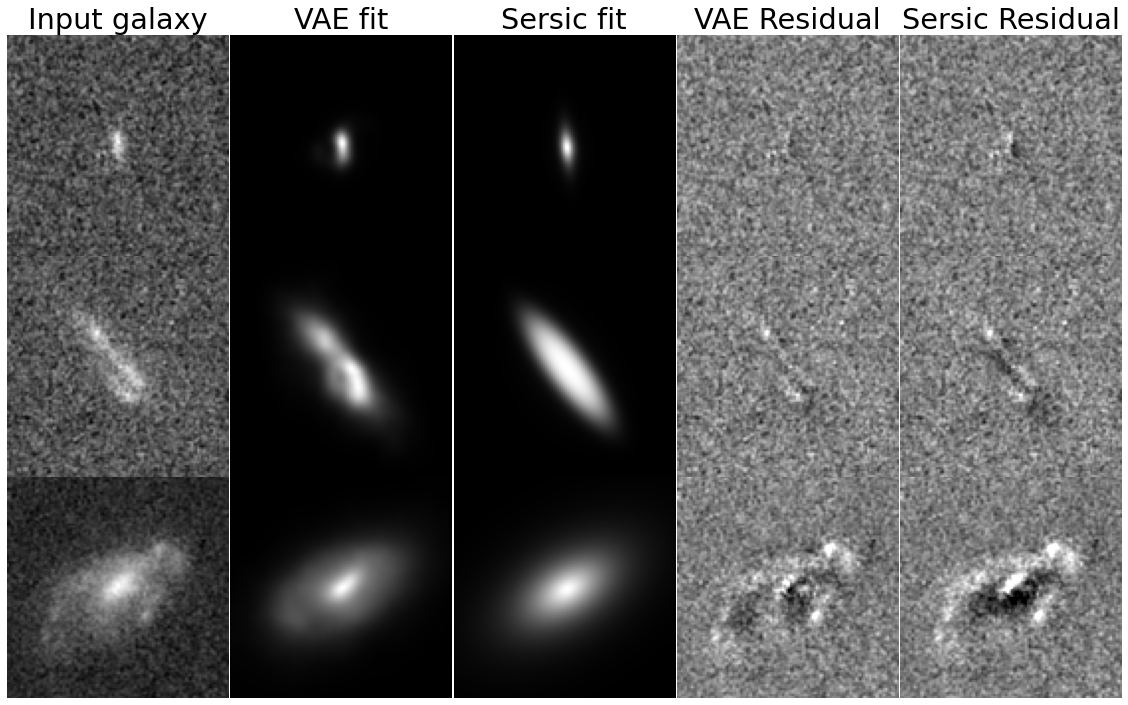

In [10]:
b=8
rcParams.update({'font.size': 24})
figure(figsize=(20,12.2))
for j in range(3):
    im_real = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_sim = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_param = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    
    # Draw the Fourier domain image of the galaxy, using x2 zero padding,
    # and x2 subsampling
    interp_factor=2
    padding_factor=1
    Nk = STAMP_SIZE*interp_factor*padding_factor
    bounds = _BoundsI(0, Nk//2, -Nk//2, Nk//2-1)    

    i = indices[j]
    
    # Drawing galaxy from cosmos
    gal = cosmos_cat.makeGalaxy(i, gal_type='real', noise_pad_size=0.8*PIXEL_SCALE*STAMP_SIZE)
    psf = gal.original_psf
    real = galsim.Convolve(psf, gal)
    real.drawImage(im_real, method='no_pixel', use_true_center=False);

    # Drawing autoencoded galaxy
    imCp = psf.drawKImage(bounds=bounds,
                         scale=2.*np.pi/(Nk * PIXEL_SCALE / interp_factor),
                         recenter=False)
    im_psf = np.abs(np.fft.fftshift(imCp.array, axes=0)).astype('float32')
    x = sess.run(reconstruction, feed_dict={psf_in:im_psf.reshape((1,256,129,1)), im_in:im_real.array.reshape((1,128,128,1))})
    im = galsim.Image(np.ascontiguousarray(x.reshape((STAMP_SIZE, STAMP_SIZE)).astype(np.float64)), scale=PIXEL_SCALE)
    sim_gal = galsim.InterpolatedImage(im)
    sim = galsim.Convolve(psf, sim_gal)
    sim.drawImage(im_sim, method='no_pixel');
    
    # Drawing galaxy from parametric model
    param_gal = cosmos_cat.makeGalaxy(i, gal_type='parametric')
    param = galsim.Convolve(psf, param_gal)
    param.drawImage(im_param, method='no_pixel', use_true_center=False);

    subplot(3,5,1+j*5)
    imshow(arcsinh(50*im_real.array[b:-b,b:-b]), cmap='gray')
    if j == 0:
        title('Input galaxy')
    axis('off')

    subplot(3,5,2+j*5)
    imshow(arcsinh(50*im_sim.array[b:-b,b:-b]), cmap='gray', vmin=0)   
    axis('off')
    if j == 0:
        title('VAE fit')
        
    subplot(3,5,3+j*5)
    imshow(arcsinh(50*im_param.array[b:-b,b:-b]), cmap='gray', vmin=0)   
    axis('off')
    if j == 0:
        title('Sersic fit')

    subplot(3,5,4+j*5)
    imshow(im_real.array[b:-b,b:-b] - im_sim.array[b:-b,b:-b], cmap='gray', vmin=-0.015, vmax=0.015)   
    axis('off');
    if j == 0:
        title('VAE Residual')

    subplot(3,5,5+j*5)
    imshow(im_real.array[b:-b,b:-b] - im_param.array[b:-b,b:-b], cmap='gray', vmin=-0.015, vmax=0.015)   
    axis('off');
    if j == 0:
        title('Sersic Residual')
    
    subplots_adjust(wspace=0, hspace=0)

subplots_adjust(wspace=0, hspace=0)
savefig('Figures/Figure_autoencode.pdf',bbox_inches='tight')

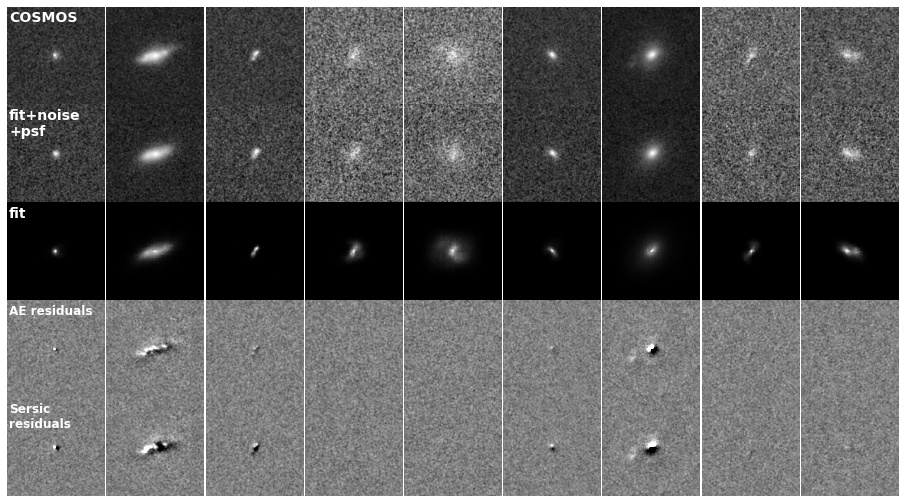

In [11]:
# Noise model
cosmos_noise = galsim.getCOSMOSNoise()

figure(figsize=(16,9))
for i in range(9):
    
    im_real = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_sim = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_sim_p = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_sim_n = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    im_param = galsim.ImageF(STAMP_SIZE, STAMP_SIZE, scale=PIXEL_SCALE)
    
    # Draw the Fourier domain image of the galaxy, using x2 zero padding,
    # and x2 subsampling
    interp_factor=2
    padding_factor=1
    Nk = STAMP_SIZE*interp_factor*padding_factor
    bounds = _BoundsI(0, Nk//2, -Nk//2, Nk//2-1)    
    
    # Drawing galaxy from cosmos, from the testing set
    gal = cosmos_cat.makeGalaxy(i+80100, gal_type='real', noise_pad_size=0.8*PIXEL_SCALE*STAMP_SIZE)
    psf = gal.original_psf
    real = galsim.Convolve(psf, gal)
    real.drawImage(im_real, method='no_pixel', use_true_center=False);

    # Drawing autoencoded galaxy
    imCp = psf.drawKImage(bounds=bounds,
                         scale=2.*np.pi/(Nk * PIXEL_SCALE / interp_factor),
                         recenter=False)
    im_psf = np.abs(np.fft.fftshift(imCp.array, axes=0)).astype('float32')
    x = sess.run(reconstruction, feed_dict={psf_in:im_psf.reshape((1,256,129,1)), im_in:im_real.array.reshape((1,128,128,1))})
    im = galsim.Image(np.ascontiguousarray(x.reshape((STAMP_SIZE, STAMP_SIZE)).astype(np.float64)), scale=PIXEL_SCALE)
    sim_gal = galsim.InterpolatedImage(im)
    sim = galsim.Convolve(psf, sim_gal)
    sim.drawImage(im_sim, method='no_pixel');
    
    sim_gal.drawImage(im_sim_p, method='no_pixel');
    
    sim.drawImage(im_sim_n, method='no_pixel');
    im_sim_n.addNoise(cosmos_noise)
    
    # Drawing galaxy from parametric model
    param_gal = cosmos_cat.makeGalaxy(i+80100, gal_type='parametric')
    param = galsim.Convolve(psf, param_gal)
    param.drawImage(im_param, method='no_pixel', use_true_center=False);
    
    subplot(5,9,i+1)
    imshow(arcsinh(50*im_real.array)/50, cmap='gray',vmin=-0.01,)
    axis('off')
    if i==0:
        text(2, 5, "COSMOS", verticalalignment='top', fontsize=14, color="white", weight="bold")
    
    subplot(5,9,i+1+9)
    imshow(arcsinh(50*im_sim_n.array)/50, cmap='gray',vmin=-0.01,)   
    axis('off')
    if i==0:
        text(2, 5, "fit+noise\n+psf", verticalalignment='top', fontsize=14, color="white", weight="bold")
        
    subplot(5,9,i+1+18)
    imshow(arcsinh(50*im_sim_p.array)/50, cmap='gray',vmin=0.0,)   
    axis('off')
    if i==0:
        text(2, 5, "fit", verticalalignment='top', fontsize=14, color="white", weight="bold")
    
    subplot(5,9,i+1+27)
    imshow( im_real.array - im_sim.array, cmap='gray',vmin=-0.02, vmax=0.02)   
    axis('off')
    if i==0:
        text(2, 5, "AE residuals", verticalalignment='top', fontsize=12, color="white", weight="bold")
        
    subplot(5,9,i+1+36)
    imshow( im_real.array - im_param.array, cmap='gray',vmin=-0.02, vmax=0.02)   
    axis('off')
    if i==0:
        text(2, 5, "Sersic\nresiduals", verticalalignment='top', fontsize=12, color="white", weight="bold")
        
plt.subplots_adjust(wspace=0, hspace=0)